In [ ]:
"""
Code modified for GitHub posting (paths are changed, some lines are removed, etc)
"""

import tqdm.notebook as tq
import os
import pandas as pd
import shutil
from shutil import copyfile
import csv
import time
import copy
from numpy import random

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchvision.io import read_image
from torchvision.io.image import ImageReadMode

----Begin manual entries----

In [ ]:
# Define class names for classification problem.
# Labels: not side: 0, side: 1
class_names = ['not_side', 'side']

# Path of dataset
path_train_val = os.path.join("dataset_path")
# Check if a folder containing the dataset and the label file already exists
if not os.path.isdir(path_train_val):
  # Create dataset location
  os.mkdir(path_train_val)

# Path of folders containing images to build dataset
front_path = 'data/train-val/train-val-front'
aug_front_path = "data/train-val/train-val-front-augmented"

back_path = "data/train-val/train-val-back"
back_aug_path = "data/train-val/train-val-back-augmented"

side_path = "data/train-val/train-val-side"
side_aug_path = "data/train-val/train-val-side-augmented"

# Name of folders (from  path_ind_classes) each class will get images from
folder_names_each_class = {'not_side':[front_path, aug_front_path, back_path, back_aug_path], 'side':[side_path, side_aug_path]}
train_percent = 0.8


# Define min val accuracy desired
min_accuracy = 0.75

# Print number of images in each class
print("front num imgs:", len(os.listdir(front_path))+len(os.listdir(aug_front_path)) + len(os.listdir(back_path)) + len(os.listdir(back_aug_path)))
print("side num imgs:", len(os.listdir(side_path)) + len(os.listdir(side_aug_path)))

In [9]:
save_model_path = "saved_models/02-20-2022.pt"
load_model_path = save_model_path

----End manual entries----

## Create Merged dataset
Files in the dataset should have names of the form, for example:<br>
0-teddybear-23.jpg. More generally, (class label)-(class name)-(image number).



In [ ]:
# Get numerical labels of classes
LABELS = {class_names[i]:i for i in range(len(class_names))}

In [ ]:
# Move images in individual class folder to dataset folder while changing file name accourdingly.
for class_name in class_names:
    k = 0
    for folder in folder_names_each_class[class_name]:
      folder_first_id = k
      # Get images from source
      class_imgs = os.listdir(folder)
      for fn in tq.tqdm(class_imgs, position=0, leave=True):
        # Create new image name
        new_fn = str(LABELS[class_name]) + "-" + class_name + "-" + os.path.split(folder)[1] + "-" + str(k)
        # Copy to dataset
        copyfile(os.path.join(folder, fn), os.path.join(path_train_val, fn))
        # Give new image name
        os.rename(os.path.join(path_train_val, fn), os.path.join(path_train_val, new_fn))

        try:
          format = PIL.Image.open(os.path.join(path_train_val, new_fn)).format
          k = k+1
        except:
          os.remove(os.path.join(path_train_val, new_fn))
          k=k
      folder_last_id = k-1
      print("added to train-val:", folder, folder_last_id - folder_first_id + 1, "images"  )

In [ ]:
print("num images in train-val:", len(os.listdir(path_train_val)))

num images in train-val: 1400


Dataset class

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, img_file_names, transform=None):    
        self.img_dir = img_dir
        self.img_file_names = img_file_names
        self.transform = transform

    def __len__(self):
        return len(self.img_file_names)

    def __getitem__(self, idx): 
        img_path = os.path.join(self.img_dir, self.img_file_names[idx])
        image = PIL.Image.open(img_path)
        image = image.convert('RGB')
        label = int(self.img_file_names[idx][0])
        if self.transform:
            image = self.transform(image)
        return image, label

Transformations for training and validation class

In [12]:
# Based on https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
data_transforms = {
'train': transforms.Compose([
    transforms.RandomRotation(degrees=(-3, 3)),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'val': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
}

Randomly split dataset into train and val data

In [ ]:
# Given a list of file names in the dataset, this function shuffles them and returns the 
# file names in the training dataset and val datasets based on what percentage of the dataset
# must be in the training dataset.
def get_train_and_val(data, train_percentage=0.8):
  dataset = np.copy(data)
  np.random.shuffle(dataset)
  N = int(len(dataset)*0.8)
  train_fn = dataset[:N]
  val_fn = dataset[N:]
  return train_fn, val_fn

Training function

In [ ]:
# Code below is from a pytorch tutorial
def train_model(device, model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, min_acc):
    since = time.time()
    model = model.to(device)
    sfmax = torch.nn.Softmax(dim=1)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch = 0

    train_acc_per_epoch = []
    val_acc_per_epoch = []

    # Discard training if we don't reach min_acc in max_epochs epochs.
    while best_acc < min_acc:
        epoch += 1
        print('Epoch', epoch)
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            print("--phase:", phase)
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            batch_num = 1
            for inputs, labels in dataloaders[phase]:

              if batch_num % 10 ==0:
                print("Batch No:", batch_num)
              batch_num += 1
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  probs = sfmax(outputs)
                  loss = criterion(outputs, labels)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'val':
              val_acc_per_epoch.append(epoch_acc)
            
            if phase == "train":
              train_acc_per_epoch.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Save model with best val accuracy
    torch.save(best_model_wts, save_model_path)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
"""
TRAIN
Imitating fine_tune() in fast.ai with pytorch


1.   Trains the randomly added layers for one epoch, with all other layers frozen.
2.   Unfreezes all of the layers, and trains them all for the number of epochs requested.
"""
def my_TF(data_path, batch_size=64):
  # GPU
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  # Get pretrained model
  model_conv = models.resnet50(pretrained=True)
  ##############################################
  #######        Prepare datasets       ########
  ##############################################
  data = os.listdir(data_path)
  # Randomly pick train and val file from all files in data
  train_fn, val_fn = get_train_and_val(data)

  # Create train and val datasets
  train_dataset = ImageDataset(path_train_val, train_fn, transform=data_transforms["train"])
  val_dataset = ImageDataset(path_train_val, val_fn, transform=data_transforms['val'])

  # Create dataloaders
  dataloaders = {"train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False), 'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=False)}
  dataset_sizes = {"train":len(train_dataset) , 'val':len(val_dataset)}

  ##############################################
  ########          Transfer           ########
  ##############################################
  criterion = nn.CrossEntropyLoss()
  ## Train only final layer. Freeze everything else. ##
  for param in model_conv.parameters():
      param.requires_grad = False

  # Replace final layer. A new layer is initialized as requires_grad = True by default.
  num_ftrs = model_conv.fc.in_features
  model_conv.fc = nn.Linear(num_ftrs, len(class_names))

  # Observe that only parameters of final layer are being optimized
  optimizer_1 = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler_1 = lr_scheduler.StepLR(optimizer_1, step_size=7, gamma=0.1)

  model_conv = train_model(device, model_conv, criterion, optimizer_1,exp_lr_scheduler_1, dataloaders, dataset_sizes, min_accuracy)

my_TF(path_train_val, batch_size=32)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 1
----------
--phase: train
Batch No: 10
Batch No: 20
Batch No: 30
train Loss: 0.6397 Acc: 0.6125
--phase: val
val Loss: 0.4868 Acc: 0.8250

Training complete in 2m 11s
Best val Acc: 0.825000


In [10]:
##############################################
##### Test on my car location images #####
##############################################
def experiment_w_model(path_exp):
  model_conv = models.resnet50(pretrained=False)
  # Replace final layer. A new layer is initialized as requires_grad = True by default.
  num_ftrs = model_conv.fc.in_features
  model_conv.fc = nn.Linear(num_ftrs, len(class_names))
  # Load saved state dict 
  model_conv.load_state_dict(torch.load(load_model_path))
  model_conv.eval()
  
  test_tf = data_transforms['val']
  
  # Only for image plotting purposes. 
  test_tf_no_Norm = transforms.Compose([
          transforms.Resize((256, 256)),
          transforms.ToTensor()])

  sfmax = torch.nn.Softmax(dim=0)
  image_names = os.listdir(path_exp)
  image_names = sorted(image_names, key=lambda x:x[2:4])
  mistakes = 0

  for img_name in image_names:
    img = PIL.Image.open(os.path.join(path_exp, img_name))
    img = img.convert('RGB')

    ## Prediction for original image ##
    img_inp = test_tf(img)

    logits = torch.squeeze(model_conv(torch.unsqueeze(img_inp, 0)), dim=0)
    probs = sfmax(logits).detach().numpy()
    
    label = int(img_name[0])
    if label != probs.argmax():
      mistakes += 1
    print("*************************************************")
    print("-File name:", img_name)
    plt.imshow(test_tf_no_Norm(img).permute(1, 2, 0))
    plt.show()
    print("-Class probabilities (descending order):")
    indicies = np.argsort(-probs)
    for j in indicies:
      print(class_names[j], ":", probs[j])
    print("-Correct class:", class_names[label]) 

  print("Num errors:", mistakes, "out of",  len(image_names) )

*************************************************
-File name: 0-01.jpeg


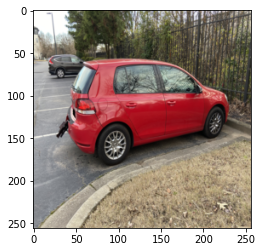

-Class probabilities (descending order):
side : 0.75836074
not_side : 0.24163927
-Correct class: not_side
*************************************************
-File name: 0-02.jpeg


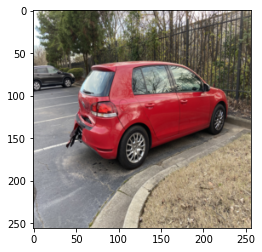

-Class probabilities (descending order):
side : 0.7174305
not_side : 0.28256956
-Correct class: not_side
*************************************************
-File name: 0-03.jpeg


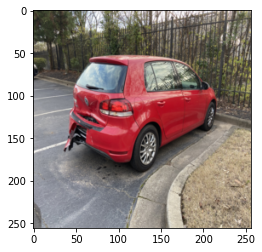

-Class probabilities (descending order):
side : 0.5637451
not_side : 0.4362549
-Correct class: not_side
*************************************************
-File name: 0-04.jpeg


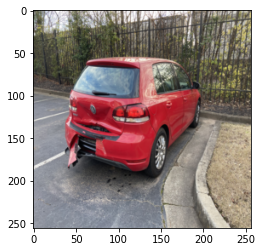

-Class probabilities (descending order):
side : 0.5649507
not_side : 0.4350493
-Correct class: not_side
*************************************************
-File name: 0-05.jpeg


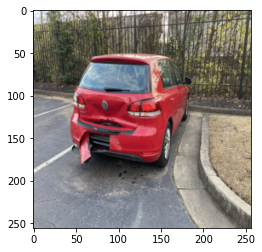

-Class probabilities (descending order):
side : 0.5203106
not_side : 0.47968945
-Correct class: not_side
*************************************************
-File name: 0-06.jpeg


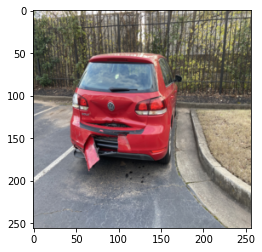

-Class probabilities (descending order):
not_side : 0.5544006
side : 0.44559932
-Correct class: not_side
*************************************************
-File name: 0-07.jpeg


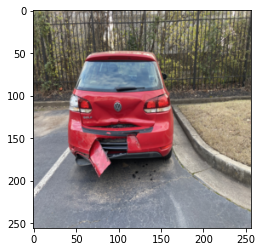

-Class probabilities (descending order):
not_side : 0.5935865
side : 0.40641356
-Correct class: not_side
Num errors: 5 out of 7


In [13]:
experiment_w_model('going-around/car_3')

USEFUL LINKS<br>
https://sparrow.dev/pytorch-normalize/<br>
Does ToTensor divide by 255?:<br>
https://discuss.pytorch.org/t/does-pytorch-automatically-normalizes-image-to-0-1/40022<br>
Warning: https://python.iitter.com/other/114438.html
